In [52]:
%config IPCompleter.use_jedi=False
%matplotlib inline

import pandas as pd
from pandas.api.types import union_categoricals
import numpy as np
import glob
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.model_selection import train_test_split
from Utils import print_memory_usage
import calendar
import math

In [30]:
#Setup for plotting
fig_width_pt = 418.25368  # Get this from LaTeX using \showthe\columnwidth, usually 500pt
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.labelsize': 10, #Was 10
          #'text.fontsize': 10,
          'legend.fontsize': 10, # Was 10
          'xtick.labelsize': 8, #Was 8
          'ytick.labelsize': 8, # was 8
          'text.usetex': True,
          'figure.figsize': fig_size}
matplotlib.rcParams.update(params)
"""
Always Save in "tight" format so there is no surplus of whitespace around the figure.
"""
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams["savefig.pad_inches"] = 0.1

In [13]:
path_full = r"Data/data_full.parquet"
path_cleaned = r"Data/data_cleaned.parquet"

Map of stations: https://account.citibikenyc.com/map

# Data loading and formatting

The whole data needs a lot of memory. We can alleviate this issue by converting start and end station ids to "categorical" dtype, and the date-time information to "datetime" format.
Furthermore, saving the data as .csv does not retain any dtype information. Therefore, we use the .parquet format instead.

First, we convert the individual files to .parquet and introduce appropriate dtypes in each file.

In [14]:
dtype = { "start station name":"category",
          "end station name":"category",
          "usertype":"category",
          "start station id":"Int64",
          "end station id":"Int64"}
datatime_format="%Y-%m-%d %H:%M:%S.%f"

In [15]:
filenames = glob.glob("Data/*-citibike-tripdata.csv")
print(filenames)

['Data/201810-citibike-tripdata.csv', 'Data/201802-citibike-tripdata.csv', 'Data/201809-citibike-tripdata.csv', 'Data/201808-citibike-tripdata.csv', 'Data/201803-citibike-tripdata.csv', 'Data/201807-citibike-tripdata.csv', 'Data/201812-citibike-tripdata.csv', 'Data/201805-citibike-tripdata.csv', 'Data/201811-citibike-tripdata.csv', 'Data/201806-citibike-tripdata.csv', 'Data/201804-citibike-tripdata.csv', 'Data/201801-citibike-tripdata.csv']


In [16]:
def convert_files(filenames,dtype,datetime_format):
    """Convert files from .csv to .parquet."""
    for filename in filenames:
        path = filename.split(".")[0]
        data = pd.read_csv(filename)
        data = data.astype(dtype,copy=False)
        data["starttime"] = pd.to_datetime(data["starttime"],format=datatime_format)
        data["stoptime"] = pd.to_datetime(data["stoptime"],format=datatime_format)
        data.to_parquet(path+".parquet",engine="pyarrow",index=False)
        

In [17]:
convert_files(filenames,dtype,datatime_format)

Now, we load the files and combine them into one large dataframe.
For the "categorical" columns, we need to union the categories of all dataframes before concatenating to avoid expanding into "object" dtype, which is memory intensive.

In [5]:
filenames_parquet = filenames = glob.glob("Data/*-citibike-tripdata.parquet")
print(filenames_parquet)

['Data/201812-citibike-tripdata.parquet', 'Data/201806-citibike-tripdata.parquet', 'Data/201802-citibike-tripdata.parquet', 'Data/201811-citibike-tripdata.parquet', 'Data/201803-citibike-tripdata.parquet', 'Data/201807-citibike-tripdata.parquet', 'Data/201808-citibike-tripdata.parquet', 'Data/201804-citibike-tripdata.parquet', 'Data/201801-citibike-tripdata.parquet', 'Data/201805-citibike-tripdata.parquet', 'Data/201809-citibike-tripdata.parquet', 'Data/201810-citibike-tripdata.parquet']


In [8]:
def load_files(filenames,categorical_cols, **kwargs):
    """Load and combine files."""
    dfs=[]
    for filename in filenames:
        d = pd.read_parquet(filename,engine="pyarrow")
        dfs.append(d)
    for col in categorical_cols:
        #We need to create unioned category types for concatenation
        #Otherwhise categorical columns are converted to object, which is too memory intensive
        uc = union_categoricals([d[col] for d in dfs])
        for d in dfs:
            d[col] = pd.Categorical(d[col],categories=uc.categories)
    data = pd.concat(dfs,ignore_index=True,copy=False)
    return data

In [9]:
data = load_files(filenames_parquet,categorical_cols=["start station name","end station name","usertype"])
print_memory_usage(data)
data.dtypes

The dataframe needs 1.81 GB of memory


tripduration                        int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start station id                    Int64
start station name               category
start station latitude            float64
start station longitude           float64
end station id                      Int64
end station name                 category
end station latitude              float64
end station longitude             float64
bikeid                              int64
usertype                         category
birth year                          int64
gender                              int64
dtype: object

In [10]:
data.to_parquet(path_full,engine="pyarrow",index=False)

# Data Cleaning

Next, we clean the data, removing some outliers and rows with missing entries.

In [92]:
data = pd.read_parquet(path_full,engine="pyarrow") #Load data if necessary

First, lets check for NAN values:

In [93]:
data.count()

tripduration               17548339
starttime                  17548339
stoptime                   17548339
start station id           17545842
start station name         17545842
start station latitude     17548339
start station longitude    17548339
end station id             17545842
end station name           17545842
end station latitude       17548339
end station longitude      17548339
bikeid                     17548339
usertype                   17548339
birth year                 17548339
gender                     17548339
dtype: int64

We see that start and end station ids and names are not always available.
This affects about 3000 of the 17 million entries.
We simply remove the rows with missing values.

In [94]:
data.dropna(inplace=True)
data.count()

tripduration               17545842
starttime                  17545842
stoptime                   17545842
start station id           17545842
start station name         17545842
start station latitude     17545842
start station longitude    17545842
end station id             17545842
end station name           17545842
end station latitude       17545842
end station longitude      17545842
bikeid                     17545842
usertype                   17545842
birth year                 17545842
gender                     17545842
dtype: int64

## Tripdurations

Next, let us have a look at the tripdurations. Because the data spans several orders of magnitude, we use a log-log plot.

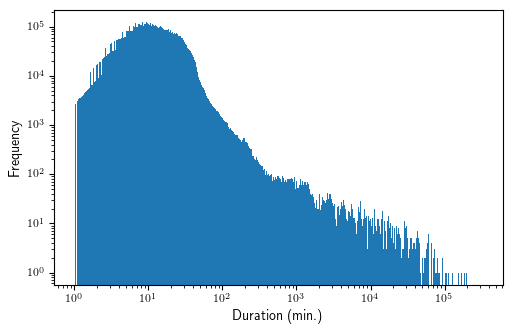

In [95]:
dur_min = data["tripduration"]/60
min_dur = dur_min.min()
max_dur = dur_min.max()
n_bins = 1000
bins = np.logspace(start = np.log10(min_dur),stop = np.log10(max_dur),num=n_bins)
ax = dur_min.plot(kind="hist",loglog=True,bins=bins)
ax.set_xlabel("Duration (min.)");
plt.savefig("Images/Tripduration.pdf")

Most trips are between 2 - 60 min.
We remove trip durations > 5 hours, since these seem unlikely inside New York.
Also note that durations < 60 seconds were already removed by the data provider, reasoning that these are likely just people trying to redock the bike.

In [96]:
duration_h = 5
longtrips = data[data["tripduration"] >= duration_h*60*60]
print(f"There are {len(longtrips)} trips of at least {duration_h} hours in the data.")
data.drop(longtrips.index,inplace=True)

There are 15454 trips of at least 5 hours in the data.


We also notice that there are round trips in the data.

There are 345517 round trips in the data


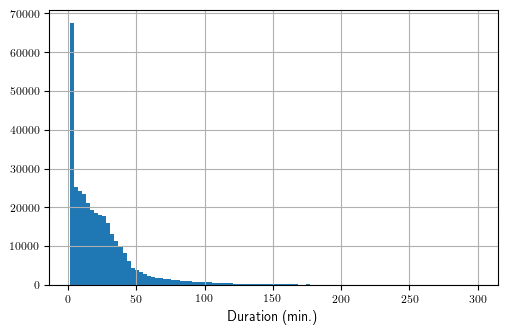

In [97]:
roundtrips = data[data["start station id"] == data["end station id"]]
print(f"There are {len(roundtrips)} round trips in the data")
ax = (roundtrips["tripduration"] / 60).hist(bins=100)
ax.set_xlabel("Duration (min.)");

Roundtrips are generally shorter than 50 min., and there is a large peak at short times:

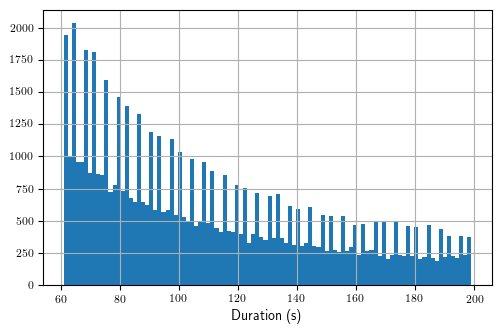

In [98]:
ax = roundtrips[roundtrips["tripduration"]<200]["tripduration"].hist(bins=100)
ax.set_xlabel("Duration (s)");

We also exclude round trips of less than 120 seconds, since these also seem like people docking their bikes.

In [99]:
shortroundtrips = roundtrips[roundtrips["tripduration"]<120]
print(f"There are {len(shortroundtrips)} short round trips in the data")
data.drop(shortroundtrips.index,inplace=True)

There are 38770 short round trips in the data


Let us furthermore indicate which trips are round trips for convenience

In [100]:
data["is_roundtrip"] = data["start station id"] == data["end station id"]
data["is_roundtrip"].value_counts()

False    17184871
True       306747
Name: is_roundtrip, dtype: Int64

## Birthyears

Next, we look at the distribution of birth years.

In [101]:
print(data["birth year"].min())
print(data["birth year"].max())

1885
2002


Since the data is from 2018, we exclude people born before 1920.

In [102]:
old = data[data["birth year"] <= 1920]
print(f"There are {len(old)} trips made by people born before 1920 in the data.")
data.drop(old.index,inplace=True)

There are 11337 trips made by people born before 1920 in the data.


## Coordinates

Next, we look at the coordinates.
New york encompasses latitudes of about between 40.6 and 40.9, and longitudes between -74.2 and -73.7

In [103]:
print(data["start station latitude"].min())
print(data["start station latitude"].max())

40.64653836709648
45.506364054011385


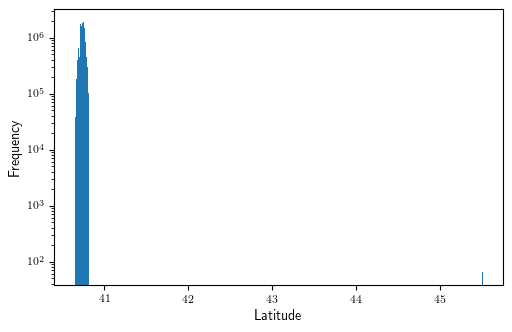

In [104]:
ax = data["start station latitude"].plot(kind="hist",logy = True,bins=600)
ax.set_xlabel("Latitude");

There appear to be around a 50 bikes lost at latitude > 45, which is somewhere around Montreal.
We exclude these.

In [105]:
lost = data[data["start station latitude"]>41]
print(len(lost))
data.drop(lost.index,inplace=True)

65


The remaining values make sense:

In [106]:
min_lat = data[["start station latitude","end station latitude"]].min().min()
max_lat = data[["start station latitude","end station latitude"]].max().max()
min_long = data[["start station longitude","end station longitude"]].min().min()
max_long = data[["start station longitude","end station longitude"]].max().max()
print(f"The latitude is between {min_lat:.2f} and {max_lat:.2f}")
print(f"The longitude is between {min_long:.2f} and {max_long:.2f}")

The latitude is between 40.65 and 40.81
The longitude is between -74.08 and -73.91


We save cleaned data for later convenience.

In [27]:
data.to_parquet(path_cleaned,index=False,engine="pyarrow")

## Computing some more features

In [9]:
data = pd.read_parquet(path_cleaned,engine="pyarrow")

There are some features that seem intuitively obvious to compute, such as the distance traveled, the speed of the bikes, whether it is a workday or weekend, and whether it is summer or winter.
We do this for the whole data set.
Since we do not use any information about the labels here, we do not need a train-test split yet.

### Distance

We approximate the length of trips by the Haversine distance between start and end point.
This is the distance "as the crow flies" and does not take into account routing.

In [107]:
def haversine(lon1, lat1, lon2, lat2):
    """    
    Calculate the great circle distance in meters between two points
    on the earth (which are specified in decimal degrees)  
    
        Taken from https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    m = (6367 * c)*1000
    return m

In [108]:
#quick sanity check, google maps claims a distance of about 1800m between these station
start = data.iloc[0]["start station name"]
end = data.iloc[0]["end station name"]
dist = haversine(data.iloc[0]["start station longitude"], data.iloc[0]["start station latitude"], data.iloc[0]["end station longitude"], data.iloc[0]["end station latitude"])
print(f"The haversine distance between {start} and {end} is {dist:.0f}m.")

The haversine distance between E 68 St & Madison Ave and E 47 St & 2 Ave is 1791m.


In [109]:
data["haversine distance"] = haversine(data["start station longitude"], data["start station latitude"], data["end station longitude"], data["end station latitude"])

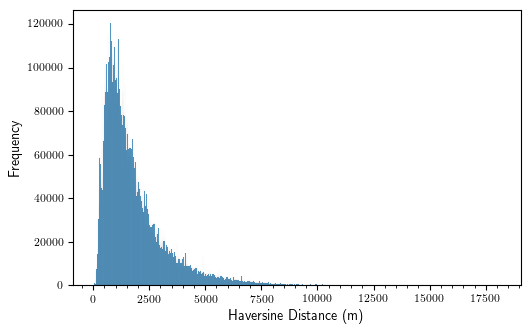

In [169]:
ax = sns.histplot(data=data[data["is_roundtrip"]==False],x="haversine distance",stat="count", color="C0");
ax.xaxis.set_minor_locator(ticker.MultipleLocator(500));
ax.set_xlabel("Haversine Distance (m)");
ax.set_ylabel("Frequency")
plt.savefig("Images/Distance.png",dpi=300) #.pdf looses color information for some reason

Next, we estimate the speed of the trips, in kmh.

In [111]:
data["speed"] = (data["haversine distance"]/1000) / (data["tripduration"]/3600) #Estimated speed in kmh

This will generally underestimate the speed because we are using haversine and not routing distance.
Since the distance in new york is given roughly by 1-norm, and haversine is 2-norm distance, the underestimate should not be by much more than a factor $\sqrt{2}$.
We see that some data points have irregular speeds over 40 kmh, and we remove these.

In [112]:
fast = data[data["speed"]>40]
print(f"There are {len(fast)} very fast trips in the data.")
data.drop(fast.index,inplace=True)
data.to_parquet(path_cleaned,index=False,engine="pyarrow")

There are 178 very fast trips in the data.


### Some information about weekday and holiday

Net, we categorize the data by business days vs holidays/weekends.

In [113]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2018-01-01', end='2018-12-31')
isholiday = data["starttime"].dt.date.astype("datetime64").isin(holidays)

In [114]:
data["holiday"] = isholiday
data["holiday"].value_counts()

False    17152139
True       327899
Name: holiday, dtype: int64

In [115]:
data["business day"] = (data["starttime"].dt.dayofweek < 5) & (~data["holiday"])
data["business day"].value_counts()

True     12938548
False     4541490
Name: business day, dtype: int64

In [116]:
#Check the number of different business days. There should be 251 for 2018.
n_businessday = data[data["business day"]]["starttime"].dt.date.nunique()
print(f"There are {n_businessday} business days.")

There are 251 business days.


In [117]:
data.to_parquet(path_cleaned,index=False,engine="pyarrow")

In [39]:
print_memory_usage(data)

The dataframe needs 2.29 GB of memory


## Unsupervised Analysis

In [90]:
data = pd.read_parquet(path_cleaned,engine="pyarrow")

We will now examine some basic properties of the data.
Since we examine the entire data set, we will be careful not to look at correlations between features and labels.

First, we notice that the data is very unbalanced. This can be a problem for supervised learning, and we will need to use appropriate training and accuracy measures.

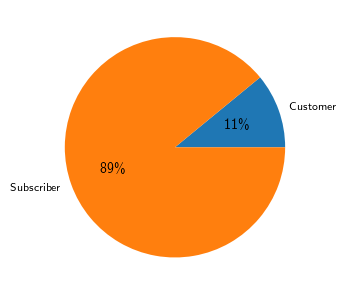

In [165]:
counts = data.groupby("usertype").size()
counts.plot.pie(autopct=r"%1.0f\%%",ylabel="");
plt.savefig("Images/Piechart.pdf")

Next, lets look at the distribution of trips over the year.

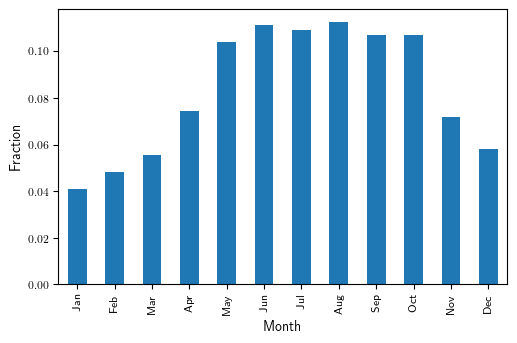

In [167]:
countbymonth = data.groupby(by = data["starttime"].dt.month).size() / len(data)
countbymonth.index.name = "Month"
ax = countbymonth.plot.bar(ylabel="Fraction");
ax.set_xticklabels(list(calendar.month_abbr)[1:]);
plt.savefig("Images/CountByMonth.pdf")

We see that there is a lot more traffic during the summer month.
This might also suggest a feature "summer", which is true from may to oct.

In [120]:
data["summer"] = (data["starttime"].dt.month >=5) & (data["starttime"].dt.month <=10)

In [121]:
data.to_parquet(path_cleaned,index=False,engine="pyarrow")

Let us also look at the distribution over weekday.

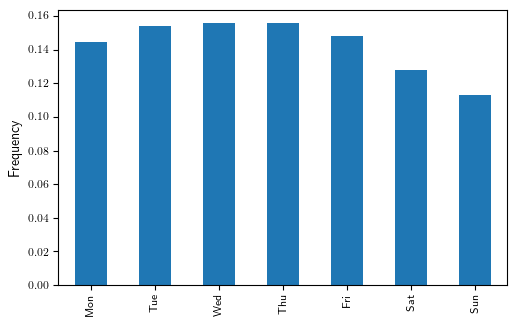

In [122]:
weekday_group = data.groupby(by = data["starttime"].dt.dayofweek)
countbyweekday = weekday_group.size() / len(data)
countbyweekday.index.name = "Weekday"
ax = countbyweekday.plot.bar(ylabel="Frequency")
ax.set_xticklabels(calendar.day_abbr);
ax.set_xlabel("");

There appears to be more traffic during the week than on weekends. We will later look at how this differs between subscribers and customers. However, people do appear to take slightly longer trips on weekends, as seen in the following graph.

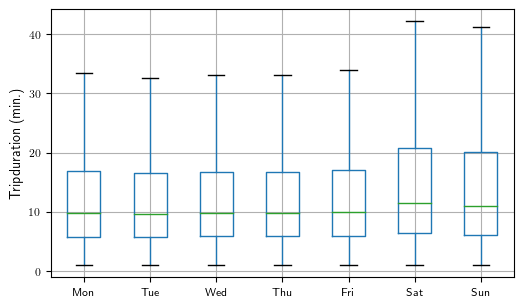

In [123]:
data["tripduration (min)"] = data["tripduration"] / 60
ax = data.boxplot(column="tripduration (min)",by=data["starttime"].dt.dayofweek,showfliers=False)
ax.set_title("")
ax.set_ylabel("Tripduration (min.)");
ax.set_xlabel("Day of Week");
plt.suptitle("")
data.drop("tripduration (min)",axis=1,inplace=True);
ax.set_xticklabels(calendar.day_abbr);
ax.set_xlabel("");

Now, we look at the distribution of trips on holidays vs business days

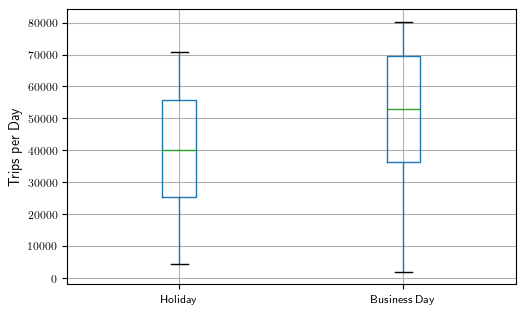

In [166]:
countbybusinessday = data.groupby(by = [data["business day"],data["starttime"].dt.date]).size()
#averagetrips = countbybusinessday.groupby(level=0).mean()
countbybusinessday=countbybusinessday.unstack().transpose()
ax = countbybusinessday.boxplot()
ax.set_ylabel("Trips per Day")
ax.set_xticklabels(["Holiday", "Business Day"]);
plt.savefig("Images/CountByBusiness.pdf")

We see that there is also more traffic on business days than holidays. Again, this might differ between subscribers and customers.

In [125]:
data.to_parquet(path_cleaned,index=False,engine="pyarrow")

# Splitting the Data

In [11]:
data = pd.read_parquet(path_cleaned,engine="pyarrow")

We now split the data into training/validation/test.
Since we have a lot of data, we will not use resampling methods such as bootstrap or cross-validation and go with a traditional split.

In [12]:
print(f"Total: {len(data)}")
n = len(data)
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
train_size = int(train_ratio*n)
val_size = int(val_ratio*n)
test_size = int(test_ratio*n)
print("Train: {0}, Val: {1}, Test: {2}".format(int(train_ratio*n), int(val_ratio*n), int(test_ratio*n)))

Total: 17480038
Train: 13984030, Val: 1748003, Test: 1748003


Let us consider how accurate our estimate of the model accuracy will be, on the test set.
We assume that we want accuracy per class.
Since the data set is very unbalanced we can only use about $10\%$ of the test set for the estimate on the rare class.
Lets say we get a true model accuracy of $99\%$.

In [13]:
f"The standard error of the estimated accuracy will be {np.sqrt(0.01*0.99 / (test_size/10)):2%}"

'The standard error of the estimated accuracy will be 0.023798%'

This seems like an acceptable error. We now split the data.

In [52]:
trainset,testset = train_test_split(data,test_size=test_size)

In [53]:
print(len(testset))
testset.to_parquet("Data/Test.parquet",index=False,engine="pyarrow")
del testset

1748003


In [54]:
trainset,valset = train_test_split(trainset,test_size=val_size)

In [55]:
print(len(trainset))
trainset.to_parquet("Data/Train.parquet",index=False,engine="pyarrow")

13984032


In [56]:
print(len(valset))
valset.to_parquet("Data/Validation.parquet",index=False,engine="pyarrow")

1748003
